# Import dataset

In [15]:
import os
import json
import pandas as pd

# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Split the path at 'scripts' and take the first part
pkg_dir = notebook_dir.split('scripts')[0]

# Define the path to the preprocessed data
preprocessed_dir = os.path.join(pkg_dir, 'data', 'preprocessed')

# Load the dataset
df = pd.read_csv(os.path.join(preprocessed_dir, 'dataset_pickplace.csv'))

# Load the column names
with open(os.path.join(preprocessed_dir, 'column_names.json'), 'r') as f:
    data = json.load(f)
conf_names = data["conf_names"]
conf_names_filt = data["conf_names_filt"]
conf_names_vel = data["conf_names_vel"]
conf_names_acc = data["conf_names_acc"]
conf_names_jerk = data["conf_names_jerk"]
param_names = data["param_names"]
kpt_names = data["kpt_names"]
kpt_names_filt = data["kpt_names_filt"]
kpt_names_vel = data["kpt_names_vel"]
kpt_names_acc = data["kpt_names_acc"]

# Select which instructions and velocities to keep
selected_instructions = [1, 3, 7]
selected_velocities = ['FAST', 'MEDIUM']

df_subset = df[(df['Instruction_id'].isin(selected_instructions)) & (df['Velocity'].isin(selected_velocities))]

# Define training and testing subjects
train_subjects = ['sub_13', 'sub_4', 'sub_6', 'sub_7', 'sub_8', 'sub_9', 'sub_10', 'sub_11']
test_subjects = ['sub_12', 'sub_3']

# Split the dataset into training and testing
train_df = df_subset[df_subset['Subject'].isin(train_subjects)]
test_df = df_subset[df_subset['Subject'].isin(test_subjects)]

print('Training dataset shape:', train_df.shape)
print('Testing dataset shape:', test_df.shape)

Training dataset shape: (23692, 309)
Testing dataset shape: (5382, 309)


# Define states and controls

In [16]:
from sindy_utils import *

only_use_upper_body = False

test = False
if test:
    print('============ TEST MODE ============')

if only_use_upper_body:
    print('Using only upper body joints')

    # Select joint coordinates in the upper body only
    upper_body_frames = ['arm', 'elbow', 'head']
    upper_body_kpts = ['0','1','2','3','4','5','6','7','14','15','16','17']

    # Check if any of the upper_body_frames strings are substrings of the names in conf_names_*
    def is_in_upper_body(name, list_of_names):
        return any(item in name for item in list_of_names)

    conf_names_upper = [name for name in conf_names if is_in_upper_body(name, upper_body_frames)]
    conf_names_filt_upper = [name for name in conf_names_filt if is_in_upper_body(name, upper_body_frames)]
    conf_names_vel_upper = [name for name in conf_names_vel if is_in_upper_body(name, upper_body_frames)]
    conf_names_acc_upper = [name for name in conf_names_acc if is_in_upper_body(name, upper_body_frames)]
    conf_names_jerk_upper = [name for name in conf_names_jerk if is_in_upper_body(name, upper_body_frames)]
    kpt_names_upper = [name for name in kpt_names if is_in_upper_body(name, upper_body_kpts)]
    kpt_names_filt_upper = [name for name in kpt_names_filt if is_in_upper_body(name, upper_body_kpts)]
    kpt_names_vel_upper = [name for name in kpt_names_vel if is_in_upper_body(name, upper_body_kpts)]
    kpt_names_acc_upper = [name for name in kpt_names_acc if is_in_upper_body(name, upper_body_kpts)]
    
    conf_names = conf_names_upper
    conf_names_filt = conf_names_filt_upper
    conf_names_vel = conf_names_vel_upper
    conf_names_acc = conf_names_acc_upper
    conf_names_jerk = conf_names_jerk_upper
    kpt_names = kpt_names_upper
    kpt_names_filt = kpt_names_filt_upper
    kpt_names_vel = kpt_names_vel_upper
    kpt_names_acc = kpt_names_acc_upper  

# x: state -> q_ddot
# u: control -> q, q_dot
state_names = conf_names_acc
state_deriv_names = conf_names_jerk
control_names = conf_names_filt + conf_names_vel
if test:
    state_names = ['x', 'y', 'z']
    control_names = ['u1', 'u2']

feature_names = state_names + control_names

# Compute the correlation matrix
train_corr = train_df[feature_names].corr()
test_corr = test_df[feature_names].corr()

# Plot the correlation matrix using plotly for the training and testing datasets
plot_correlation_matrix(train_corr, 'Correlation Matrix - Training Data')
plot_correlation_matrix(test_corr, 'Correlation Matrix - Testing Data')

# Compute the KL divergence between the training and testing datasets for each feature
# The KL divergence is a measure of how much one probability distribution differs from a second, reference probability distribution
# A KL divergence of 0 indicates that the two distributions are identical
for feature in feature_names:
    kl_div = compute_kl_divergence(train_df[feature], test_df[feature])
    print('KL Divergence for', feature, ':\t\t', kl_div)

KL Divergence for ddq_chest_pos_x :		 0.13234554401077037
KL Divergence for ddq_chest_pos_y :		 0.37646315575597344
KL Divergence for ddq_chest_pos_z :		 0.03795918442752986
KL Divergence for ddq_chest_rot_x :		 0.03421371904477012
KL Divergence for ddq_chest_rot_y :		 0.019452556103218582
KL Divergence for ddq_chest_rot_z :		 0.06187652583821221
KL Divergence for ddq_chest_rot_w :		 0.040023455471435765
KL Divergence for ddq_shoulder_rot_x :		 0.059590426024194364
KL Divergence for ddq_hip_rot_z :		 0.17917877446656516
KL Divergence for ddq_hip_rot_x :		 1.1024534866155844
KL Divergence for ddq_right_arm_rot_z :		 0.032362036164820786
KL Divergence for ddq_right_arm_rot_x :		 0.029748291503385885
KL Divergence for ddq_right_arm_rot_y :		 0.09339769278426038
KL Divergence for ddq_right_elbow_rot_z :		 0.03331672202927687
KL Divergence for ddq_left_arm_rot_z :		 0.025905539344013316
KL Divergence for ddq_left_arm_rot_x :		 0.5024091273024839
KL Divergence for ddq_left_arm_rot_y :		 0.17

# Exploratory Data Analysis (Visualization)

In [17]:
import numpy as np

# Retrieve data from the training dataset
subject = train_subjects[0]
instruction = selected_instructions[0]
velocity = selected_velocities[0]

print(f"Subject: {subject}, Instruction: {instruction}, Velocity: {velocity}")
data_filter = (train_df["Subject"] == subject) & (train_df["Instruction_id"] == instruction) & (train_df["Velocity"] == velocity)

X_filt = train_df[data_filter][conf_names_filt].values
Xdot = train_df[data_filter][conf_names_vel].values
Xddot = train_df[data_filter][conf_names_acc].values
Xdddot = train_df[data_filter][conf_names_jerk].values
t = train_df[data_filter]["Time"].values
kpt_filt = train_df[data_filter][kpt_names_filt].values
kpt_vel = train_df[data_filter][kpt_names_vel].values
kpt_acc = train_df[data_filter][kpt_names_acc].values

# Select a joint-space variable to plot
var_to_plot = 'q_right_elbow_rot_z'
plot_idx = np.where(np.array(conf_names) == var_to_plot)[0][0]

# Select which cartesian variable to plot (wrist x,y,z position)
plot_idxs_cartesian = None
if 'right' in var_to_plot or 'left' in var_to_plot:
    kpt_number = 4 if 'right' in var_to_plot else 7
    plot_idxs_cartesian = [kpt_names.index(s) for s in [f'human_kp{kpt_number}_x', f'human_kp{kpt_number}_y', f'human_kp{kpt_number}_z']]
else:
    plot_idxs_cartesian = None

plot_differentiation(X_filt, Xdot, Xddot, Xdddot, t,
                     subject, conf_names, 
                     plot_idx, plot_idxs_cartesian,
                     kpt_filt, kpt_vel, kpt_acc)

Subject: sub_13, Instruction: 1, Velocity: FAST


# Define Training and Validation Datasets

In [18]:
if test:        
    states_train, states_deriv_train, inputs_train, \
    states_test, states_test_deriv, inputs_test, \
    time_train, time_test = test_lorenz()

    states_train_list = [states_train]
    states_deriv_train_list = [states_deriv_train]
    inputs_train_list = [inputs_train]
    time_train_list = [time_train]

    states_test_list = [states_test]
    states_deriv_test_list = [states_test_deriv]
    inputs_test_list = [inputs_test]
    time_test_list = [time_test]

else:
    # Define the training data
    states_train_list = []
    states_deriv_train_list = []
    inputs_train_list = []
    time_train_list = []
    train_traj_idx = []

    counter = 0
    for sub in train_subjects:
        for instruction in selected_instructions:
            for velocity in selected_velocities:
                selection_filter = (train_df['Subject'] == sub) & (train_df['Instruction_id'] == instruction) & (train_df['Velocity'] == velocity)
                states_train = train_df[selection_filter][state_names].values
                states_deriv_train = train_df[selection_filter][state_deriv_names].values
                inputs_train = train_df[selection_filter][control_names].values
                time_train = train_df[selection_filter]['Time'].values

                states_train_list.append(states_train)
                states_deriv_train_list.append(states_deriv_train)
                inputs_train_list.append(inputs_train)
                time_train_list.append(time_train)

                iter_data = dict(counter=counter, subject=sub, instruction=instruction, velocity=velocity)
                train_traj_idx.append(iter_data)

                counter += 1

                print(f'TRAINING DATASET, Trajectory {counter}: \tSubject {sub}, Instruction {instruction} ',
                      f'Velocity {velocity}\t- number of samples: {states_train.shape[0]}')

    # Define the validation data
    states_test_list = []
    states_deriv_test_list = []
    inputs_test_list = []
    time_test_list = []
    test_traj_idx = []

    counter = 0
    for sub in test_subjects:
        for instruction in selected_instructions:
            for velocity in selected_velocities:
                selection_filter = (test_df['Subject'] == sub) & (test_df['Instruction_id'] == instruction) & (test_df['Velocity'] == velocity)
                states_test = test_df[selection_filter][state_names].values
                states_deriv_test = test_df[selection_filter][state_deriv_names].values
                inputs_test = test_df[selection_filter][control_names].values
                time_test = test_df[selection_filter]['Time'].values

                states_test_list.append(states_test)
                states_deriv_test_list.append(states_deriv_test)
                inputs_test_list.append(inputs_test)
                time_test_list.append(time_test)

                iter_data = dict(counter=counter, subject=sub, instruction=instruction, velocity=velocity)
                test_traj_idx.append(iter_data)

                counter += 1

                print(f'VALIDATION DATASET, Trajectory {counter}: \tSubject {sub}, Instruction {instruction} ',
                      f'Velocity {velocity}\t- number of samples: {states_test.shape[0]}')   

num_training_samples = sum([states_train.shape[0] for states_train in states_train_list])
num_validation_samples = sum([states_test.shape[0] for states_test in states_test_list])
num_training_datapoints = num_training_samples * len(feature_names)
num_validation_datapoints = num_validation_samples * len(feature_names)

print(f'\nNumber of TRAINING samples:\t\t{num_training_samples}')
print(f'Number of TRAINING datapoints:\t\t{num_training_datapoints}')
print(f'Number of VALIDATION samples:\t\t{num_validation_samples}')
print(f'Number of VALIDATION datapoints:\t{num_validation_datapoints}')

TRAINING DATASET, Trajectory 1: 	Subject sub_13, Instruction 1  Velocity FAST	- number of samples: 362
TRAINING DATASET, Trajectory 2: 	Subject sub_13, Instruction 1  Velocity MEDIUM	- number of samples: 694
TRAINING DATASET, Trajectory 3: 	Subject sub_13, Instruction 3  Velocity FAST	- number of samples: 355
TRAINING DATASET, Trajectory 4: 	Subject sub_13, Instruction 3  Velocity MEDIUM	- number of samples: 694
TRAINING DATASET, Trajectory 5: 	Subject sub_13, Instruction 7  Velocity FAST	- number of samples: 365
TRAINING DATASET, Trajectory 6: 	Subject sub_13, Instruction 7  Velocity MEDIUM	- number of samples: 697
TRAINING DATASET, Trajectory 7: 	Subject sub_4, Instruction 1  Velocity FAST	- number of samples: 302
TRAINING DATASET, Trajectory 8: 	Subject sub_4, Instruction 1  Velocity MEDIUM	- number of samples: 509
TRAINING DATASET, Trajectory 9: 	Subject sub_4, Instruction 3  Velocity FAST	- number of samples: 300
TRAINING DATASET, Trajectory 10: 	Subject sub_4, Instruction 3  Velo

# Define the SINDy libraries of functions

If the polynomial and fourier libraries are **tensored** together, make sure that (*max_poly_degree* + *fourier_n_freq* <= 2), otherwise memory runs out.<br>The number of coefficients becomes huge.

However, if the libraries are simply **concatenated** instead of tensored, *max_poly_degree* and *fourier_n_freq* can be increased.

In [19]:
import pysindy as ps

sampling_time = 0.01
max_poly_degree = 1
fourier_n_freq = 1
use_poly = True
use_fourier = True
use_custom = True # True for ONLY_UPPER_BODY ON OLD DATASET ONLY ON PICK-AND-PLACE
tensor_libraries = False # Not working for CUSTOM library yet ???

# Define the feature libraries
poly_library = ps.PolynomialLibrary(degree=max_poly_degree,
                                    include_bias=True,            # include a bias term (constant feature)
                                    include_interaction=False)    # include mixed terms (e.g. x1*x2) - if True: up to degree max_poly_degree
                                                                  #                                  - if False: up to degree max_poly_degree-1
fourier_library = ps.FourierLibrary(n_frequencies=fourier_n_freq)

# THESE WORKED FOR ONLY_UPPER_BODY ON OLD DATASET ONLY ON PICK-AND-PLACE
# custom_lib_f = [
#     lambda x: 1.0 / (x + 1.0/sampling_time),
#     lambda x: 1.0 / (x + 1.0/sampling_time)**2,
#     lambda x: 1.0 / (x + 1.0/sampling_time)**(-1),
#     lambda x: 1.0 / (x + 1.0/sampling_time)**(-2),
#     lambda x: np.sin(x)**2,
#     lambda x: np.cos(x)**2,
#     lambda x: np.sin(x)*np.cos(x),
# ]
# custom_lib_f_names = [
#     lambda x: f'1 / ( {x} + {1.0/sampling_time} )',
#     lambda x: f'1 / ( {x} + {1.0/sampling_time} )^2',
#     lambda x: f'1 / ( {x} + {1.0/sampling_time} )^(-1)',
#     lambda x: f'1 / ( {x} + {1.0/sampling_time} )^(-2)',
#     lambda x: f'sin({x})^2',
#     lambda x: f'cos({x})^2',
#     lambda x: f'sin({x}) * cos({x})',
# ]

custom_lib_f = [
    lambda x: 1.0 / (x + 1.0/sampling_time),
    # lambda x: 1.0 / (x + 1.0/sampling_time)**2,
    # lambda x: 1.0 / (x + 1.0/sampling_time)**(-1),
    # lambda x: 1.0 / (x + 1.0/sampling_time)**(-2),
    # lambda x: np.sin(x)**2,
    # lambda x: np.cos(x)**2,
    # lambda x: np.sin(x)*np.cos(x),
]
custom_lib_f_names = [
    lambda x: f'1 / ( {x} + {1.0/sampling_time} )',
    # lambda x: f'1 / ( {x} + {1.0/sampling_time} )^2',
    # lambda x: f'1 / ( {x} + {1.0/sampling_time} )^(-1)',
    # lambda x: f'1 / ( {x} + {1.0/sampling_time} )^(-2)',
    # lambda x: f'sin({x})^2',
    # lambda x: f'cos({x})^2',
    # lambda x: f'sin({x}) * cos({x})',
]
custom_library = ps.CustomLibrary(library_functions=custom_lib_f,
                                  function_names=custom_lib_f_names)

if tensor_libraries:
    n_libraries = sum([use_poly, use_fourier, use_custom])
    # Initialize the default inputs, i.e. each library
    # uses all the input variables (states+inputs)
    inputs_idx = np.arange(len(feature_names))
    inputs_per_library = [inputs_idx for _ in range(n_libraries)]

    # Tensor all the polynomial and Fourier library terms together
    tensor_array = [[1, 1]]

    # Combine the libraries using tensorization
    generalized_library = ps.GeneralizedLibrary([poly_library, fourier_library],
                                                tensor_array=tensor_array,
                                                inputs_per_library=inputs_per_library # type: ignore
    )
else:
    # Combine the libraries using concatenation
    generalized_library = None
    lib_initialized = False
    
    if use_poly:
        generalized_library = poly_library
        lib_initialized = True
        print(f'Using Polynomial library with max degree {max_poly_degree}')
    if use_fourier:
        if lib_initialized:
            generalized_library = generalized_library + fourier_library # type: ignore
        else:
            generalized_library = fourier_library
            lib_initialized = True
        print(f'Using Fourier library with {fourier_n_freq} frequencies')
    if use_custom:
        if lib_initialized:
            generalized_library = generalized_library + custom_library # type: ignore
        else:
            generalized_library = custom_library
            lib_initialized = True
        print(f'Using Custom library with {len(custom_lib_f)} terms')
    if not lib_initialized:
        raise ValueError('No library selected')

Using Polynomial library with max degree 1
Using Fourier library with 1 frequencies
Using Custom library with 1 terms


# Tune algorithm hyperparameter $\lambda$ (threshold)


=== BEWARE: Suppressing UserWarnings temporarily! ===

Thresholds to scan: ['1.0000e-03', '1.8330e-03', '3.3598e-03', '6.1585e-03', '1.1288e-02', '2.0691e-02', '3.7927e-02', '6.9519e-02', '1.2743e-01', '2.3357e-01', '4.2813e-01', '7.8476e-01', '1.4384e+00', '2.6367e+00', '4.8329e+00', '8.8587e+00', '1.6238e+01', '2.9764e+01', '5.4556e+01', '1.0000e+02']


Model feature names:
0: 1
1: ddq_chest_pos_x
2: ddq_chest_pos_y
3: ddq_chest_pos_z
4: ddq_chest_rot_x
5: ddq_chest_rot_y
6: ddq_chest_rot_z
7: ddq_chest_rot_w
8: ddq_shoulder_rot_x
9: ddq_hip_rot_z
10: ddq_hip_rot_x
11: ddq_right_arm_rot_z
12: ddq_right_arm_rot_x
13: ddq_right_arm_rot_y
14: ddq_right_elbow_rot_z
15: ddq_left_arm_rot_z
16: ddq_left_arm_rot_x
17: ddq_left_arm_rot_y
18: ddq_left_elbow_rot_z
19: ddq_right_leg_rot_z
20: ddq_right_leg_rot_x
21: ddq_right_leg_rot_y
22: ddq_right_knee_rot_z
23: ddq_left_leg_rot_z
24: ddq_left_leg_rot_x
25: ddq_left_leg_rot_y
26: ddq_left_knee_rot_z
27: ddq_head_rot_z
28: ddq_head_rot_x
29: f

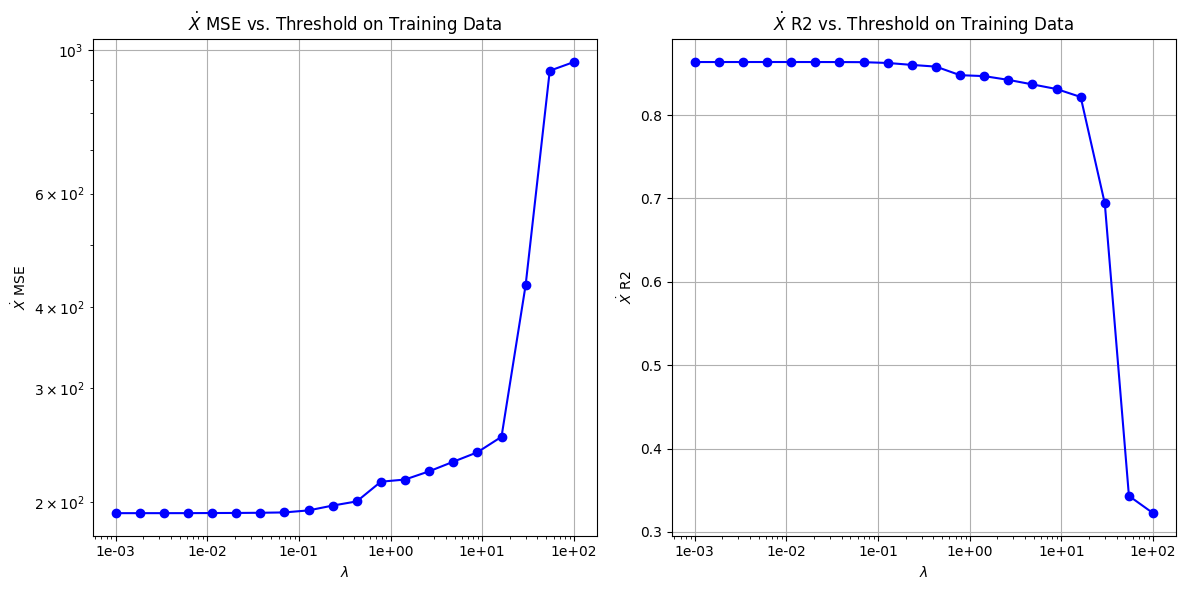

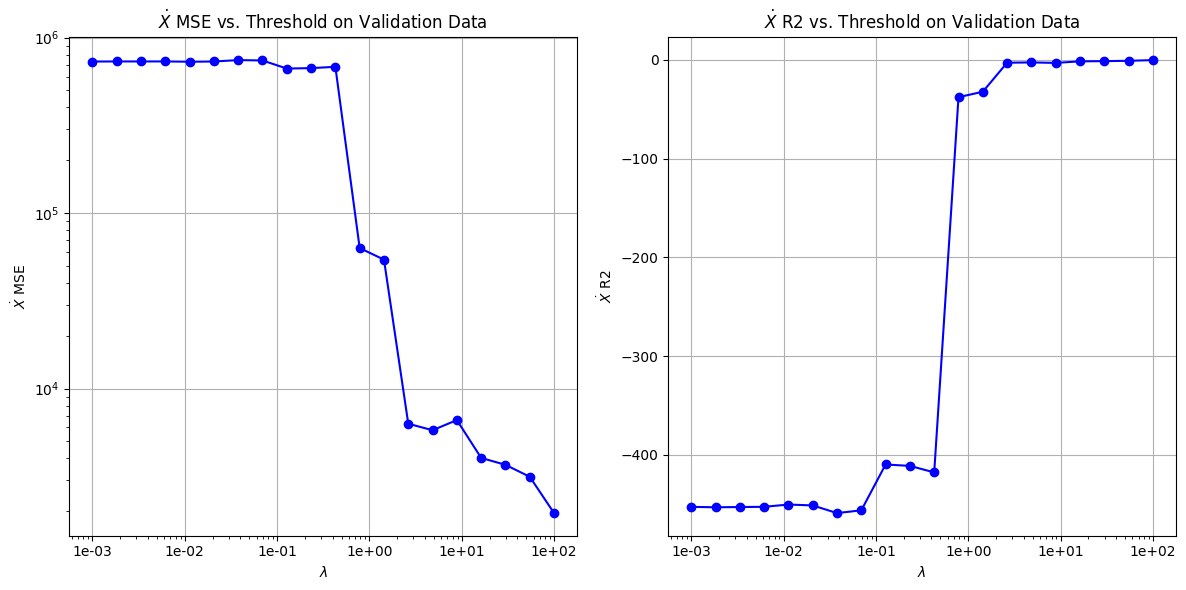


TRAINING on subjects '['sub_13', 'sub_4', 'sub_6', 'sub_7', 'sub_8', 'sub_9', 'sub_10', 'sub_11']', VALIDATION on subjects ['sub_12', 'sub_3']:
Best threshold: 1.0000e+02
	MSE [training]: 9.5896e+02	MSE [validation]: 1.9507e+03
	Adj. R2 [training]: 3.2249e-01	Adj. R2 [validation]: -1.8689e-01


In [20]:
from sklearn.metrics import mean_squared_error

# Temporarily suppress warnings
import warnings
warnings.simplefilter("ignore", category=UserWarning)
print("\n=== BEWARE: Suppressing UserWarnings temporarily! ===\n")

### INITIALIZE SCAN PARAMETERS ###
# Define flag to enable ensamble optimization
ensemble_optimization = False

# Define the threshold values to scan
threshold_scan = np.logspace(-3, 2, 20)
if test:
    threshold_scan = np.linspace(0, 1.0, 11)
print(f'Thresholds to scan: {[f"{threshold:.4e}" for threshold in threshold_scan]}\n')

### SCAN THE THRESHOLD VALUES, FIT THE MODEL, AND EVALUATE THE PERFORMANCE ###
mse_train_array = []
r2_train_array = []
mse_test_array = []
r2_test_array = []

for threshold in threshold_scan:
    # Define the optimizer
    if not ensemble_optimization:
        optimizer = ps.STLSQ(threshold=threshold,
                             normalize_columns=False)
    else:
        subsampling_factor = 0.6
        optimizer = ps.EnsembleOptimizer(
            ps.STLSQ(threshold=threshold,
                    normalize_columns=False),
            bagging=True,
            n_subset=int(subsampling_factor * num_training_samples)
        )

    # Define the SINDy model
    model = ps.SINDy(feature_names=feature_names,
                     feature_library=generalized_library,
                     optimizer=optimizer
    )

    # Fit the model
    model.fit(states_train_list,
              u=inputs_train_list,
              x_dot=states_deriv_train_list,
              t=time_train_list
    )
    
    # On 1st iteration only: Print the list of model feature names with their corresponding indices
    if threshold == threshold_scan[0]:
        print(f'\nModel feature names:')
        features = model.get_feature_names()
        for i, feature in enumerate(features):
            print(f'{i}: {feature}')

    # Get the coefficients
    if not ensemble_optimization:
        coefficients = model.coefficients()
    else:
        ensemble_coefs = optimizer.coef_list # type: ignore
        coefficients = np.mean(ensemble_coefs, axis=0)
        std_ensemble = np.std(ensemble_coefs, axis=0)

    # Compute the number of coefficients whose absolute value is above the threshold (also the percentage)
    num_coeffs_sparse = np.sum(np.abs(coefficients) >= threshold)
    num_coeff_sparse_percent = num_coeffs_sparse / (coefficients.shape[0] * coefficients.shape[1]) * 100

    # Score the model (training)
    mse_train = model.score(states_train_list,
                            u=inputs_train_list,
                            x_dot=states_deriv_train_list,
                            metric=mean_squared_error
    )
    r2_score_train = model.score(states_train_list,
                                 u=inputs_train_list,
                                 x_dot=states_deriv_train_list,
                                 metric=adjusted_r2_score, # custom_r2_score,
                                 n_samples=num_training_datapoints,
                                 n_features=num_coeffs_sparse
    )

    # Score the model (validation)
    mse_test = model.score(states_test_list,
                            u=inputs_test_list,
                            x_dot=states_deriv_test_list,
                            metric=mean_squared_error
    )
    r2_score_test = model.score(states_test_list,
                                u=inputs_test_list,
                                x_dot=states_deriv_test_list,
                                metric=adjusted_r2_score, # custom_r2_score,
                                n_samples=num_validation_datapoints,
                                n_features=num_coeffs_sparse
    )

    # Print the results
    print(f'\n=> Threshold: {threshold:.4e}' \
            f' | # coeffs above threshold: {num_coeffs_sparse}' \
            f' | Percentage of coeffs kept: {num_coeff_sparse_percent:.0f}%\n' \
            f'\t# training datapoints: {num_training_datapoints}' \
            f'\t# validation datapoints: {num_validation_datapoints}\n' \
            f'\tMSE [training]: {mse_train:.4e}' \
            f'\tMSE [validation]: {mse_test:.4e}\n' \
            f'\tAdj. R2 [training]: {r2_score_train:.4e}' \
            f'\tAdj. R2 [validation]: {r2_score_test:.4e}')
    
    if test:
        model.get_feature_names()
        model.print()

    # Plot the sparsity pattern of the coefficients
    # plot_coefficients_threshold(coefficients, feature_names, threshold=threshold, scale_viz=True)

    # Store the results
    mse_train_array.append(mse_train)
    r2_train_array.append(r2_score_train)
    mse_test_array.append(mse_test)
    r2_test_array.append(r2_score_test)


# Check which model is the best on the validation set (evaluated based on the MSE)
best_idx = np.argmin(mse_test_array)
best_mse_test = mse_test_array[best_idx]
best_r2_test = r2_test_array[best_idx]
best_threshold_test = threshold_scan[best_idx]
mse_train_for_best_test = mse_train_array[best_idx]
r2_train_for_best_test = r2_train_array[best_idx]

# Plot the Pareto front for the MSE and R2 in the training and validation set
plot_pareto(threshold_scan, mse_train_array, r2_train_array, mse_test_array, r2_test_array, test)

print(f"\nTRAINING on subjects '{train_subjects}', VALIDATION on subjects {test_subjects}:\n" \
        f'Best threshold: {best_threshold_test:.4e}\n' \
        f'\tMSE [training]: {mse_train_for_best_test:.4e}' \
        f'\tMSE [validation]: {best_mse_test:.4e}\n' \
        f'\tAdj. R2 [training]: {r2_train_for_best_test:.4e}' \
        f'\tAdj. R2 [validation]: {best_r2_test:.4e}')

# Fit a model ensemble to improve SINDy performance

- Use the regularization threshold optimized with the procedure above
- Sample the entire time series with replacement with duplicates

See:
1. https://pysindy.readthedocs.io/en/stable/examples/1_feature_overview/example.html#Ensemble-methods
2. https://github.com/dynamicslab/pysindy/blob/master/examples/13_ensembling.ipynb

In [21]:
selected_threshold = best_threshold_test

# Define the optimizer
if not ensemble_optimization:
    optimizer = ps.STLSQ(threshold=selected_threshold,
                         normalize_columns=False)
else:
    subsampling_factor = 0.6
    optimizer = ps.EnsembleOptimizer(
        ps.STLSQ(threshold=selected_threshold,
                normalize_columns=False),
        bagging=True,
        n_subset=int(subsampling_factor * num_training_samples)
    )

# Define the SINDy model
model = ps.SINDy(feature_names=feature_names,
                 feature_library=generalized_library,
                 optimizer=optimizer
)

# Fit the model
model.fit(states_train_list,
          u=inputs_train_list,
          x_dot=states_deriv_train_list,
          t=time_train_list
)


# Define the path to the preprocessed data
models_dir = os.path.join(pkg_dir, 'models')

# Save the fitted model to a pickle file
import dill
with open(os.path.join(models_dir, 'sindy_model.pkl'), 'wb') as f:
    dill.dump(model, f)
print("Model saved to 'sindy_model.pkl'")

Model saved to 'sindy_model.pkl'


# Extract Model Coefficients

In [22]:
# Load the fitted model from the pickle file
with open(os.path.join(models_dir, 'sindy_model.pkl'), 'rb') as f:
    model = dill.load(f)
print("Model loaded from 'sindy_model.pkl'")

# Get the feature names
features = model.get_feature_names()
for i, feature in enumerate(features):
    print(f'{i}: {feature}')
    
# Get the coefficients
if not ensemble_optimization:
    coefficients = model.coefficients()
else:
    ensemble_coefs = optimizer.coef_list # type: ignore
    coefficients = np.mean(ensemble_coefs, axis=0)
    coefficients_std = np.std(ensemble_coefs, axis=0)

# Plot the sparsity pattern of the coefficients
plot_coefficients_threshold(coefficients, feature_names, threshold=selected_threshold, scale_viz=True)

if ensemble_optimization:
    # Plot the standard deviation of the coefficients
    plot_coefficients_threshold(coefficients_std, feature_names, threshold=0.0, scale_viz=False) # CHECK

Model loaded from 'sindy_model.pkl'
0: 1
1: ddq_chest_pos_x
2: ddq_chest_pos_y
3: ddq_chest_pos_z
4: ddq_chest_rot_x
5: ddq_chest_rot_y
6: ddq_chest_rot_z
7: ddq_chest_rot_w
8: ddq_shoulder_rot_x
9: ddq_hip_rot_z
10: ddq_hip_rot_x
11: ddq_right_arm_rot_z
12: ddq_right_arm_rot_x
13: ddq_right_arm_rot_y
14: ddq_right_elbow_rot_z
15: ddq_left_arm_rot_z
16: ddq_left_arm_rot_x
17: ddq_left_arm_rot_y
18: ddq_left_elbow_rot_z
19: ddq_right_leg_rot_z
20: ddq_right_leg_rot_x
21: ddq_right_leg_rot_y
22: ddq_right_knee_rot_z
23: ddq_left_leg_rot_z
24: ddq_left_leg_rot_x
25: ddq_left_leg_rot_y
26: ddq_left_knee_rot_z
27: ddq_head_rot_z
28: ddq_head_rot_x
29: filt_q_chest_pos_x
30: filt_q_chest_pos_y
31: filt_q_chest_pos_z
32: filt_q_chest_rot_x
33: filt_q_chest_rot_y
34: filt_q_chest_rot_z
35: filt_q_chest_rot_w
36: filt_q_shoulder_rot_x
37: filt_q_hip_rot_z
38: filt_q_hip_rot_x
39: filt_q_right_arm_rot_z
40: filt_q_right_arm_rot_x
41: filt_q_right_arm_rot_y
42: filt_q_right_elbow_rot_z
43: filt_q

# Score the model

In [23]:
# Compute the number of coefficients whose absolute value is above the threshold (also the percentage)
num_coeffs_sparse = np.sum(np.abs(coefficients) >= threshold)
num_coeff_sparse_percent = num_coeffs_sparse / (coefficients.shape[0] * coefficients.shape[1]) * 100

# Score the model (training)
mse_train = model.score(states_train_list,
                        u=inputs_train_list,
                        x_dot=states_deriv_train_list,
                        metric=mean_squared_error
)
r2_score_train = model.score(states_train_list,
                             u=inputs_train_list,
                             x_dot=states_deriv_train_list,
                             metric=adjusted_r2_score, # custom_r2_score,
                             n_samples=num_training_datapoints,
                             n_features=num_coeffs_sparse
)

# Score the model (validation)
mse_test = model.score(states_test_list,
                        u=inputs_test_list,
                        x_dot=states_deriv_test_list,
                        metric=mean_squared_error
)
r2_score_test = model.score(states_test_list,
                            u=inputs_test_list,
                            x_dot=states_deriv_test_list,
                            metric=adjusted_r2_score, # custom_r2_score,
                            n_samples=num_validation_datapoints,
                            n_features=num_coeffs_sparse
)

# Print the results
print(f'Threshold: {selected_threshold:.4e}' \
      f' | # coeffs above threshold: {num_coeffs_sparse}' \
      f' | Percentage of coeffs kept: {num_coeff_sparse_percent:.0f}%\n' \
      f'\t# training datapoints: {num_training_datapoints}' \
      f'\t\t# validation datapoints: {num_validation_datapoints}\n' \
      f'\tMSE [training]: {mse_train:.4e}' \
      f'\t\tMSE [validation]: {mse_test:.4e}\n' \
      f'\tAdj. R2 [training]: {r2_score_train:.4e}' \
      f'\t\tAdj. R2 [validation]: {r2_score_test:.4e}')

Threshold: 1.0000e+02 | # coeffs above threshold: 109 | Percentage of coeffs kept: 1%
	# training datapoints: 1990128		# validation datapoints: 452088
	MSE [training]: 9.5896e+02		MSE [validation]: 1.9507e+03
	Adj. R2 [training]: 3.2249e-01		Adj. R2 [validation]: -1.8689e-01


# Predict derivatives with the learned model

In [24]:
states_deriv_pred_list = []
for traj, input, t in zip(states_test_list, inputs_test_list, time_test_list):
    states_deriv_pred = model.predict(traj, u=input)
    states_deriv_pred_list.append(states_deriv_pred)

# Simulate the model forward in time to predict future states

In [25]:
# print("All simulations completed")
from scipy.integrate import solve_ivp

def sindy_model(t, y, input, deriv_dict):
    # Find the two closest keys around the given t
    keys = np.array(list(deriv_dict.keys()))
    idx = np.searchsorted(keys, t)
    
    if idx == 0:
        t0, t1 = keys[0], keys[1]
    elif idx == len(keys):
        t0, t1 = keys[-2], keys[-1]
    else:
        t0, t1 = keys[idx - 1], keys[idx]
    
    # Interpolate between the corresponding values
    deriv0, deriv1 = deriv_dict[t0], deriv_dict[t1]
    interpolated_deriv = deriv0 + (deriv1 - deriv0) * (t - t0) / (t1 - t0)

    return interpolated_deriv

states_pred_list = []
for i in range(len(states_test_list)):
    traj = states_test_list[i]
    input = inputs_test_list[i]
    t = time_test_list[i]
    deriv = states_deriv_pred_list[i]

    # Create a dictionary where keys are elements of t and values are elements of deriv
    deriv_dict = {t[j]: deriv[j] for j in range(len(t))}

    states_pred = solve_ivp(sindy_model, [t[0], t[-1]], traj[0], t_eval=t, args=(input, deriv_dict,))
    states_pred_list.append(states_pred.y.T)

In [26]:
# Select which state derivative to plot
derivative_to_plot = 'ddq_right_arm_rot_z'
plot_idx = np.where(np.array(state_names) == derivative_to_plot)[0][0]

sub_to_plot = test_subjects[0]
instr_to_plot = selected_instructions[0]
vel_to_plot = selected_velocities[0]

# Retrieve the data for the selected trajectory
traj_to_plot = [i for i, traj in enumerate(test_traj_idx)
                if traj['subject'] == sub_to_plot
                    and traj['instruction'] == instr_to_plot
                    and traj['velocity'] == vel_to_plot
               ][0] # find the trajectory index

states_deriv_pred = states_deriv_pred_list[traj_to_plot]
states_deriv_true = states_deriv_test_list[traj_to_plot]

states_pred = states_pred_list[traj_to_plot]
states_true = states_test_list[traj_to_plot]

# Plot the predicted vs. true derivatives
fig = go.Figure()
fig.add_trace(go.Scatter
                (x=time_test_list[traj_to_plot],
                    y=states_deriv_pred[:, plot_idx],
                    mode='lines',
                    line=dict(color='blue', width=1),
                    name=f'Prediction ({sub_to_plot}, {instr_to_plot}, {vel_to_plot})'
                )
)
fig.add_trace(go.Scatter
                (x=time_test_list[traj_to_plot],
                    y=states_deriv_true[:, plot_idx],
                    mode='lines',
                    line=dict(color='red', width=1),
                    name=f'True ({sub_to_plot}, {instr_to_plot}, {vel_to_plot})'
                )
)
    
fig.update_layout(title=f'Predicted vs. True State Derivative: {derivative_to_plot}',
                  xaxis_title='Time [s]',
                  yaxis_title='Derivative',
                  showlegend=True
)

fig.show()

# Plot the predicted vs. true states
fig = go.Figure()
fig.add_trace(go.Scatter
                (x=time_test_list[traj_to_plot],
                    y=states_pred[:, plot_idx],
                    mode='lines',
                    line=dict(color='blue', width=1),
                    name=f'Prediction ({sub_to_plot}, {instr_to_plot}, {vel_to_plot})'
                )
)
fig.add_trace(go.Scatter
                (x=time_test_list[traj_to_plot],
                    y=states_true[:, plot_idx],
                    mode='lines',
                    line=dict(color='red', width=1),
                    name=f'True ({sub_to_plot}, {instr_to_plot}, {vel_to_plot})'
                )
)

fig.update_layout(title=f'Predicted vs. True State: {derivative_to_plot}',
                    xaxis_title='Time [s]',
                    yaxis_title='State',
                    showlegend=True
    )

fig.show()

# Integrate the state (joint acceleration) to get velocity and position

In [27]:
# Integrate the predicted accelerations to get the velocities
joint_vel_pred_list = []
for i in range(len(states_pred_list)):
    states_pred = states_pred_list[i]
    t = time_test_list[i]

    joint_vel_pred = np.zeros(states_pred.shape)
    for j in range(states_pred.shape[1]):
        joint_vel_pred[:, j] = np.cumsum(states_pred[:, j]) * np.mean(np.diff(t))

    joint_vel_pred_list.append(joint_vel_pred)

# Integrate the predicted velocities to get the positions
joint_pos_pred_list = []
for i in range(len(joint_vel_pred_list)):
    joint_vel_pred = joint_vel_pred_list[i]
    t = time_test_list[i]

    joint_pos_pred = np.zeros(joint_vel_pred.shape)
    for j in range(joint_vel_pred.shape[1]):
        joint_pos_pred[:, j] = np.cumsum(joint_vel_pred[:, j]) * np.mean(np.diff(t))

    joint_pos_pred_list.append(joint_pos_pred)

In [28]:
# Select which joint position/velocity to plot
joint_pos_to_plot = derivative_to_plot.replace('ddq', 'filt_q')
joint_vel_to_plot = derivative_to_plot.replace('ddq', 'dq')

plot_idx_pred = np.where(np.array(state_names) == derivative_to_plot)[0][0]
plot_idx_pos = np.where(np.array(control_names) == joint_pos_to_plot)[0][0]
plot_idx_vel = np.where(np.array(control_names) == joint_vel_to_plot)[0][0]

# Retrieve the data for the selected trajectory
traj_to_plot = [i for i, traj in enumerate(test_traj_idx)
                if traj['subject'] == sub_to_plot
                    and traj['instruction'] == instr_to_plot
                    and traj['velocity'] == vel_to_plot
               ][0] # find the trajectory index

joint_vel_pred = joint_vel_pred_list[traj_to_plot]
joint_pos_pred = joint_pos_pred_list[traj_to_plot]
joint_true = inputs_test_list[traj_to_plot]

# Plot the predicted vs. true joint velocities
v0 = joint_true[0, plot_idx_vel]

fig = go.Figure()
fig.add_trace(go.Scatter
                (x=time_test_list[traj_to_plot],
                    y=joint_vel_pred[:, plot_idx_pred] + v0,
                    mode='lines',
                    line=dict(color='blue', width=1),
                    name=f'Prediction ({sub_to_plot}, {instr_to_plot}, {vel_to_plot})'
                )
)
fig.add_trace(go.Scatter
                (x=time_test_list[traj_to_plot],
                    y=joint_true[:, plot_idx_vel],
                    mode='lines',
                    line=dict(color='red', width=1),
                    name=f'True ({sub_to_plot}, {instr_to_plot}, {vel_to_plot})'
                )
)

fig.update_layout(title=f'Predicted vs. True Joint Velocity: {joint_vel_to_plot}',
                    xaxis_title='Time [s]',
                    yaxis_title='Velocity',
                    showlegend=True
)

fig.show()

# Plot the predicted vs. true joint positions
y0 = joint_true[0, plot_idx_pos]

fig = go.Figure()
fig.add_trace(go.Scatter
                (x=time_test_list[traj_to_plot],
                    y=joint_pos_pred[:, plot_idx_pred] + y0,
                    mode='lines',
                    line=dict(color='blue', width=1),
                    name=f'Prediction ({sub_to_plot}, {instr_to_plot}, {vel_to_plot})'
                )
)
fig.add_trace(go.Scatter
                (x=time_test_list[traj_to_plot],
                    y=joint_true[:, plot_idx_pos],
                    mode='lines',
                    line=dict(color='red', width=1),
                    name=f'True ({sub_to_plot}, {instr_to_plot}, {vel_to_plot})'
                )
)

fig.update_layout(title=f'Predicted vs. True Joint Position: {joint_pos_to_plot}',
                    xaxis_title='Time [s]',
                    yaxis_title='Position',
                    showlegend=True
)

fig.show()

In [29]:
TODO:
- check why ensemble model not working
- integrate this model in the Kalman pipeline

SyntaxError: invalid syntax (4130461850.py, line 1)